# VidmaPy examples

* [Compute ATLAS model](#Compute-ATLAS-model)
* [Compare models with different metallicity and carbon abundance](#Compare-models-with-different-metallicity-and-carbon-abundance)
* [Compute SYNSPEC synthetic spectra with different abundance](#Compute-SYNSPEC-synthetic-spectra-with-different-abundance)
* [Parallelization of spectra computation](#Parallelization-of-spectra-computation)
* [Compute ATLAS models and SYNTHE spectra with different helium abundance](#Compute-ATLAS-models-and-SYNTHE-spectra-with-different-helium-abundance)

In [1]:
# because Jupyter notebook is not in package
import os,sys,inspect
current_dir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parent_dir = os.path.dirname(current_dir)
sys.path.insert(0, parent_dir)

In [2]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

<a id='ex1'></a>
## Compute ATLAS model

In [3]:
from vidmapy.kurucz.atlas import Atlas
from vidmapy.kurucz.parameters import Parameters

In [4]:
p= Parameters(teff=10000,
               logg=3.6,
               metallicity=0.0,
               microturbulence=2.)

atlas_worker= Atlas()
model= atlas_worker.get_model(p)

TEFF  = 10000
LOGG  = 3.6
[M/H] = 0.0
TITLE : TEFF=10000, LOGG=3.60, [M/H]=0.00, VMIC=2
--------------------------------



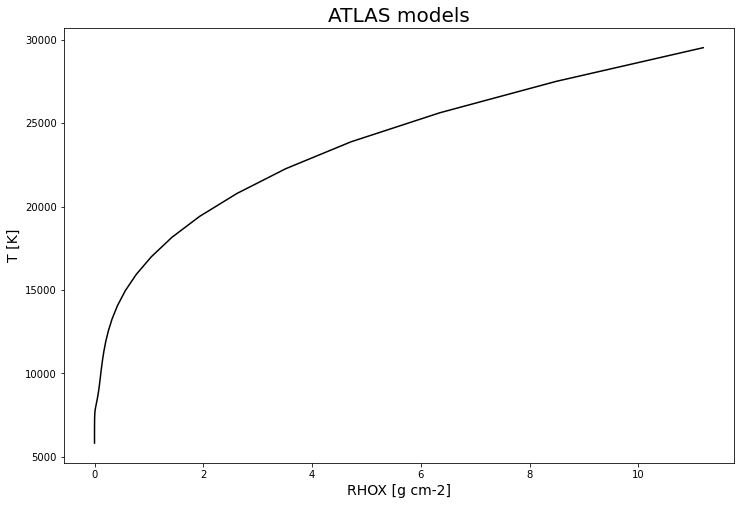

In [5]:
print(model)
plt.figure(figsize=(12,8))
plt.title("ATLAS models", fontsize=20)
plt.plot(model.structure["RHOX"], model.structure["T"],'k')
plt.xlabel("RHOX [g cm-2]", fontsize=14)
plt.ylabel("T [K]", fontsize=14)
plt.show()

[Back to the top](#VidmaPy-examples)

<a id='ex2'></a>
## Compare models with different metallicity and carbon abundance

In [6]:
from vidmapy.kurucz.atlas import Atlas
from vidmapy.kurucz.parameters import Parameters

In [7]:
p_me03= Parameters(teff=10000,
               logg=3.6,
               metallicity=0.3,
               microturbulence=2.)
p_me03.chemical_composition["C"] = -2.7

p_me_30= Parameters(teff=10000,
               logg=3.6,
               metallicity=-3.0,
               microturbulence=2.)

atlas_worker= Atlas()
model_me03= atlas_worker.get_model(p_me03)
model_me_30= atlas_worker.get_model(p_me_30)

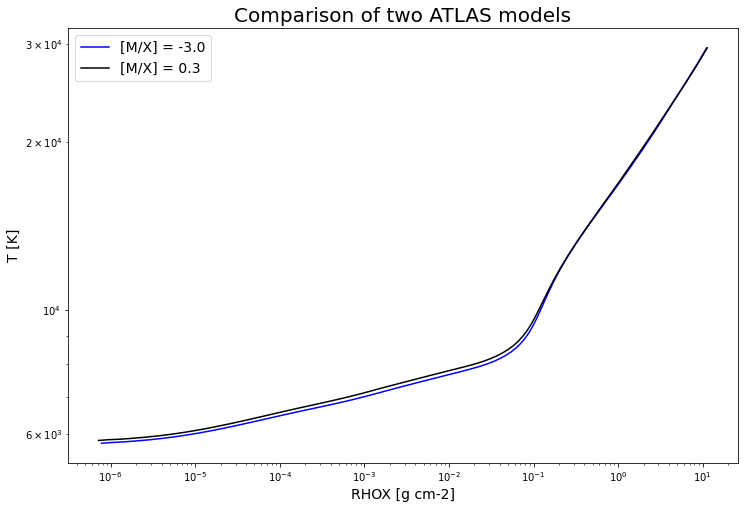

In [8]:
plt.figure(figsize=(12,8))
plt.title("Comparison of two ATLAS models", fontsize=20)
plt.loglog(model_me_30.structure["RHOX"], model_me_30.structure["T"],'b', label='[M/X] = -3.0')
plt.loglog(model_me03.structure["RHOX"], model_me03.structure["T"],'k', label='[M/X] = 0.3')
plt.xlabel("RHOX [g cm-2]", fontsize=14)
plt.ylabel("T [K]", fontsize=14)
plt.legend(fontsize=14)
plt.show()

[Back to the top](#VidmaPy-examples)

<a id='ex3'></a>
## Compute SYNSPEC synthetic spectra with different abundance

In [9]:
from vidmapy.kurucz.atlas import Atlas
from vidmapy.kurucz.synthe import Synthe
from vidmapy.kurucz.parameters import Parameters

In [10]:
p_me00= Parameters(teff=10000,
               logg=3.5,
               metallicity=0.0,
               microturbulence=2.)

atlas_worker= Atlas()
model_me00= atlas_worker.get_model(p_me00)

In [11]:
# NOTE: We can use the same model for computation of spectra with modified metallicity/abundace
p_synthe_me00= Parameters(wave_min=5000, 
                     wave_max=5100, 
                     resolution=40000, 
                     metallicity=0.0,
                    )

p_synthe_me00_Si= Parameters(wave_min=5000, 
                     wave_max=5100, 
                     resolution=40000, 
                     metallicity=0.0,
                    )
p_synthe_me00_Si.chemical_composition['Si'] = -4.49 + 0.3

p_synthe_me_03= Parameters(wave_min=5000, 
                     wave_max=5100, 
                     resolution=40000, 
                     metallicity=-0.3,
                    )

synthe_worker= Synthe()
spectrum_me00 = synthe_worker.get_spectrum(model_me00, parameters=p_synthe_me00, quiet=True)
spectrum_me00_Si = synthe_worker.get_spectrum(model_me00, parameters=p_synthe_me00_Si, quiet=True)
spectrum_me_03 = synthe_worker.get_spectrum(model_me00, parameters=p_synthe_me_03, quiet=True)

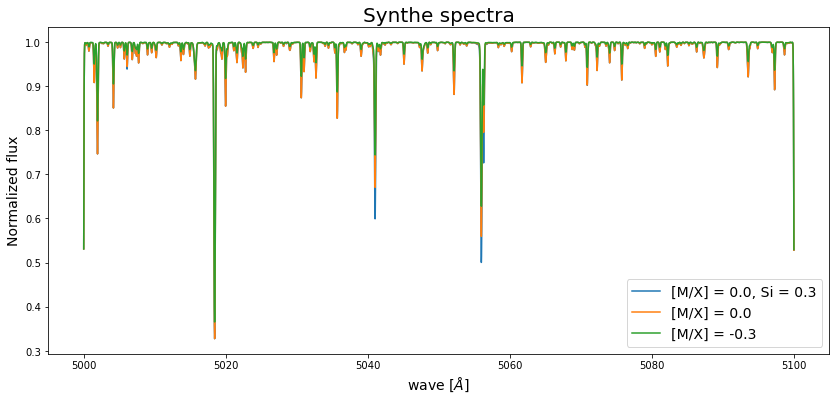

In [12]:
plt.figure(figsize=(14,6))
plt.title("Synthe spectra",fontsize=20)

plt.plot(spectrum_me00_Si.wave, spectrum_me00_Si.normed_flux, label='[M/X] = 0.0, Si = 0.3')
plt.plot(spectrum_me00.wave, spectrum_me00.normed_flux, label='[M/X] = 0.0')
plt.plot(spectrum_me_03.wave, spectrum_me_03.normed_flux, label='[M/X] = -0.3')

plt.xlabel(r"wave [$\AA$]", fontsize=14)
plt.ylabel("Normalized flux", fontsize=14)
plt.legend(fontsize=14)
plt.show()

[Back to the top](#VidmaPy-examples)

<a id='ex4'></a>
## Parallelization of spectra computation

In [13]:
from vidmapy.kurucz.atlas import Atlas
from vidmapy.kurucz.synthe import Synthe
from vidmapy.kurucz.parameters import Parameters
import multiprocessing as mp

In [14]:
# Create model
p= Parameters(teff=10000,
               logg=3.5,
               metallicity=0.0,
               microturbulence=2.)

atlas_worker= Atlas()
model_me00= atlas_worker.get_model(p)

In [15]:
# Define parameters and synthe workers
Si_abundances =  -4.49 + np.arange(-3.0, 1.5, 0.15)
parameters = [Parameters(wave_min=5000, 
                     wave_max=5100, 
                     resolution=40000,
                     Si=ab) for ab in Si_abundances]

workers = [Synthe() for _ in range(len(parameters))]

In [16]:
len(parameters)

30

In [17]:
# Run in parallel
no_of_processes = 30
pool = mp.Pool(processes=no_of_processes)

results = [pool.apply_async(worker.get_spectrum, args=(model_me00, parameter, True))\
                            for worker, parameter in zip(workers, parameters)]
results = [r.get() for r in results]
pool.close()
pool.join()

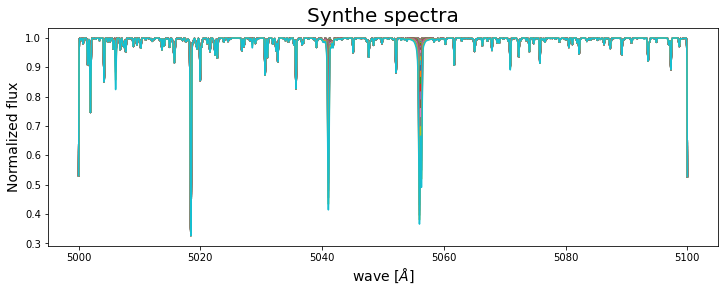

In [18]:
plt.figure(figsize=(12,4))
plt.title("Synthe spectra",fontsize=20)

for spectrum in results:
    plt.plot(spectrum.wave, spectrum.normed_flux)

plt.xlabel(r"wave [$\AA$]", fontsize=14)
plt.ylabel("Normalized flux", fontsize=14)
plt.show()

[Back to the top](#VidmaPy-examples)

<a id='ex4'></a>
## Compute ATLAS models and SYNTHE spectra with different helium abundance

In [19]:
from vidmapy.kurucz.atlas import Atlas
from vidmapy.kurucz.synthe import Synthe
from vidmapy.kurucz.parameters import Parameters

In [20]:
p_He= Parameters(teff=15000,
                  logg=4.0,
                  metallicity=0.0,
                  microturbulence=2.)
p_He.chemical_composition["He"] = 0.0007
p_He.chemical_composition["H"] = 1 - 0.00126 - p_He.chemical_composition["He"]

p= Parameters(teff=15000,
               logg=4.0,
               metallicity=0.0,
               microturbulence=2.)

atlas_worker= Atlas()
model_He= atlas_worker.get_model(p_He)
model= atlas_worker.get_model(p)

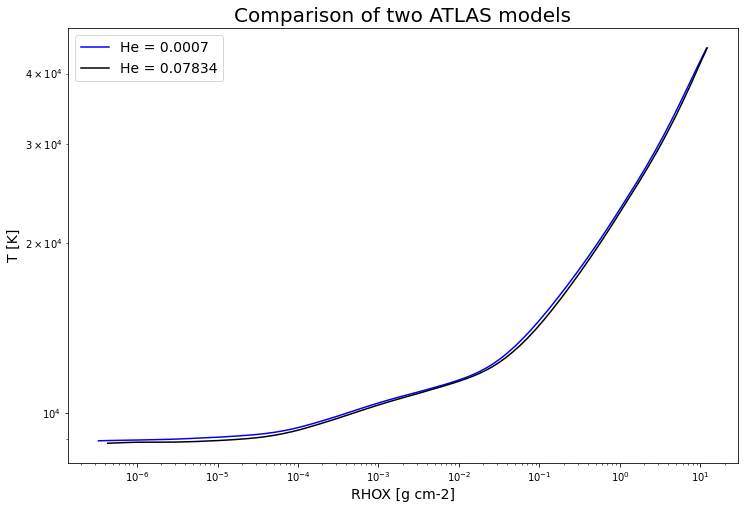

In [21]:
plt.figure(figsize=(12,8))
plt.title("Comparison of two ATLAS models", fontsize=20)

plt.loglog(model_He.structure["RHOX"], model_He.structure["T"],'b', 
           label=f'He = {p_He.chemical_composition["He"]}')

plt.loglog(model.structure["RHOX"], model.structure["T"],'k', 
           label='He = 0.07834')

plt.xlabel("RHOX [g cm-2]", fontsize=14)
plt.ylabel("T [K]", fontsize=14)
plt.legend(fontsize=14)
plt.show()

In [22]:
synthe_worker= Synthe()
spectrum_He = synthe_worker.get_spectrum(model_He)
spectrum = synthe_worker.get_spectrum(model)

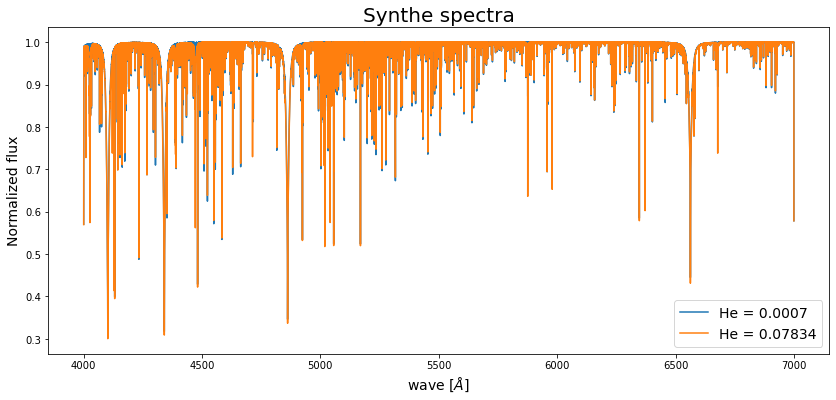

In [23]:
plt.figure(figsize=(14,6))
plt.title("Synthe spectra",fontsize=20)

plt.plot(spectrum_He.wave, spectrum_He.normed_flux, 
         label=f'He = {spectrum_He.parameters.chemical_composition["He"]}')
plt.plot(spectrum.wave, spectrum.normed_flux, label='He = 0.07834')

plt.xlabel(r"wave [$\AA$]", fontsize=14)
plt.ylabel("Normalized flux", fontsize=14)
plt.legend(fontsize=14)
plt.show()